<a href="https://colab.research.google.com/github/ShraddhaSharma24/Generative-AI-Projects/blob/main/Anime_Face_Generation_using_DCGAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step	Description

✅ Dataset	Cartoon/Anime face images (auto-downloaded, no manual hassle)

✅ Preprocessing	Resize, normalize, blur to create paired data (input/target)

✅ Dataset Class	Custom AnimeFaceDataset with image pair logic

✅ Visualization	Sanity check of input-target pairing using matplotlib

🛠️ Model Training	Coming up next! (or basic architecture if already tested)

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")


Using: cuda


In [2]:
!pip install -U gdown
!gdown 1OwJL-wMCrTLycTf3ZngzWQPYPlfiCMLn --fuzzy -O anime_faces.zip
!unzip -q anime_faces.zip -d anime_faces


Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1OwJL-wMCrTLycTf3ZngzWQPYPlfiCMLn

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open anime_faces.zip, anime_faces.zip.zip or anime_faces.zip.ZIP.


In [3]:
!wget https://huggingface.co/datasets/skarami/anime-faces/resolve/main/images.zip
!unzip -q images.zip -d anime_faces


--2025-04-05 08:50:24--  https://huggingface.co/datasets/skarami/anime-faces/resolve/main/images.zip
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.118, 18.164.174.23, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.
unzip:  cannot find or open images.zip, images.zip.zip or images.zip.ZIP.


In [4]:
import os
import zipfile

from google.colab import files

uploaded = files.upload()

# Move kaggle.json to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install the Kaggle CLI
!pip install -q kaggle


Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d splcher/animefacedataset
!unzip -q animefacedataset.zip -d anime_faces


Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0


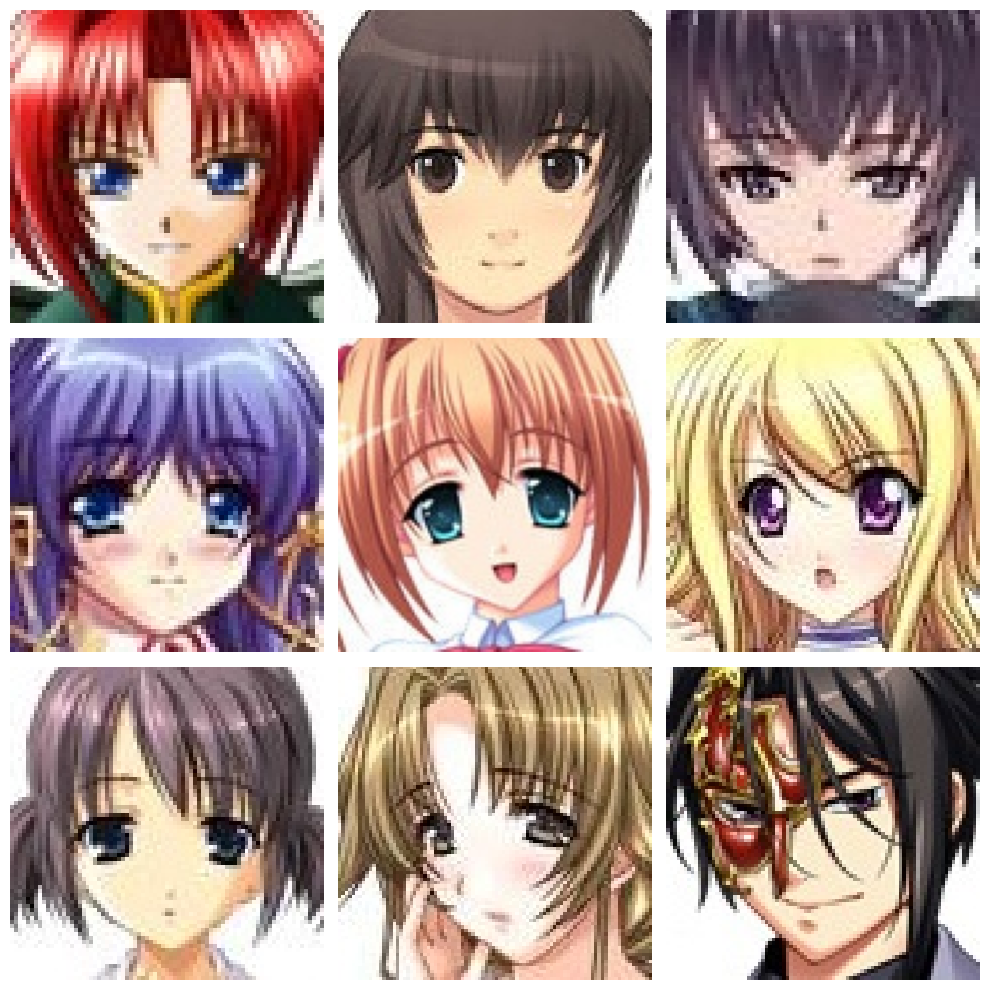

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

img_dir = "/content/anime_faces/images"
sample_imgs = os.listdir(img_dir)[:9]

plt.figure(figsize=(10, 10))
for i, img_file in enumerate(sample_imgs):
    img = Image.open(os.path.join(img_dir, img_file))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [7]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os


In [8]:
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        blurred = gaussian_blur(image, kernel_size=5)
        return blurred, image  # input, target



In [9]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])


In [10]:
dataset = AnimeFaceDataset("/content/anime_faces/images", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)



In [12]:
from torchvision.transforms.functional import gaussian_blur

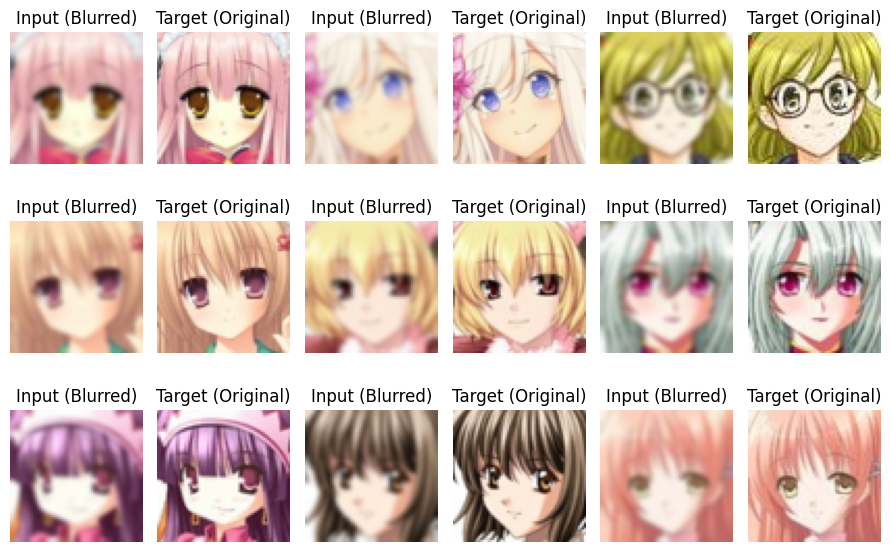

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Assuming normalization was (0.5, 0.5, 0.5)

# Fetch a batch
input_imgs, target_imgs = next(iter(dataloader))

# Visualize first 9 input and target pairs
plt.figure(figsize=(9, 6))
for i in range(9):
    plt.subplot(3, 6, 2*i + 1)
    img = denormalize(input_imgs[i])
    npimg = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(npimg)
    plt.title("Input (Blurred)")
    plt.axis("off")

    plt.subplot(3, 6, 2*i + 2)
    img = denormalize(target_imgs[i])
    npimg = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(npimg)
    plt.title("Target (Original)")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [14]:
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super(UNetGenerator, self).__init__()

        def down_block(in_c, out_c, use_bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_c, out_c, dropout=False):
            layers = [
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            ]
            if dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.down1 = down_block(3, features, use_bn=False)
        self.down2 = down_block(features, features * 2)
        self.down3 = down_block(features * 2, features * 4)
        self.down4 = down_block(features * 4, features * 8)
        self.down5 = down_block(features * 8, features * 8)

        self.up1 = up_block(features * 8, features * 8, dropout=True)
        self.up2 = up_block(features * 16, features * 4)
        self.up3 = up_block(features * 8, features * 2)
        self.up4 = up_block(features * 4, features)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)  # [B, 64, 32, 32]
        d2 = self.down2(d1)  # [B, 128, 16, 16]
        d3 = self.down3(d2)  # [B, 256, 8, 8]
        d4 = self.down4(d3)  # [B, 512, 4, 4]
        bottleneck = self.down5(d4)  # [B, 512, 2, 2]

        u1 = self.up1(bottleneck)  # [B, 512, 4, 4]
        u2 = self.up2(torch.cat([u1, d4], dim=1))  # skip connection
        u3 = self.up3(torch.cat([u2, d3], dim=1))
        u4 = self.up4(torch.cat([u3, d2], dim=1))
        out = self.final_up(torch.cat([u4, d1], dim=1))
        return out


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = UNetGenerator().to(device)


In [16]:
from torchvision.transforms.functional import gaussian_blur

def blur_image(img_tensor, kernel_size=5):
    return gaussian_blur(img_tensor, kernel_size=kernel_size)


In [17]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.L1Loss()
optimizer = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [18]:
num_epochs = 5  # keep it light for now
gen.train()

for epoch in range(num_epochs):
    for i, (input_img, target_img) in enumerate(dataloader):
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        output = gen(input_img)
        loss = criterion(output, target_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] Loss: {loss.item():.4f}")


[Epoch 0/5] [Batch 0/1987] Loss: 0.7174
[Epoch 0/5] [Batch 50/1987] Loss: 0.1490
[Epoch 0/5] [Batch 100/1987] Loss: 0.1252
[Epoch 0/5] [Batch 150/1987] Loss: 0.1023
[Epoch 0/5] [Batch 200/1987] Loss: 0.1025
[Epoch 0/5] [Batch 250/1987] Loss: 0.0890
[Epoch 0/5] [Batch 300/1987] Loss: 0.0830
[Epoch 0/5] [Batch 350/1987] Loss: 0.0817
[Epoch 0/5] [Batch 400/1987] Loss: 0.0733
[Epoch 0/5] [Batch 450/1987] Loss: 0.0764
[Epoch 0/5] [Batch 500/1987] Loss: 0.0789
[Epoch 0/5] [Batch 550/1987] Loss: 0.0729
[Epoch 0/5] [Batch 600/1987] Loss: 0.0687
[Epoch 0/5] [Batch 650/1987] Loss: 0.0699
[Epoch 0/5] [Batch 700/1987] Loss: 0.0677
[Epoch 0/5] [Batch 750/1987] Loss: 0.0653
[Epoch 0/5] [Batch 800/1987] Loss: 0.0630
[Epoch 0/5] [Batch 850/1987] Loss: 0.0664
[Epoch 0/5] [Batch 900/1987] Loss: 0.0655
[Epoch 0/5] [Batch 950/1987] Loss: 0.0625
[Epoch 0/5] [Batch 1000/1987] Loss: 0.0597
[Epoch 0/5] [Batch 1050/1987] Loss: 0.0621
[Epoch 0/5] [Batch 1100/1987] Loss: 0.0580
[Epoch 0/5] [Batch 1150/1987] Loss

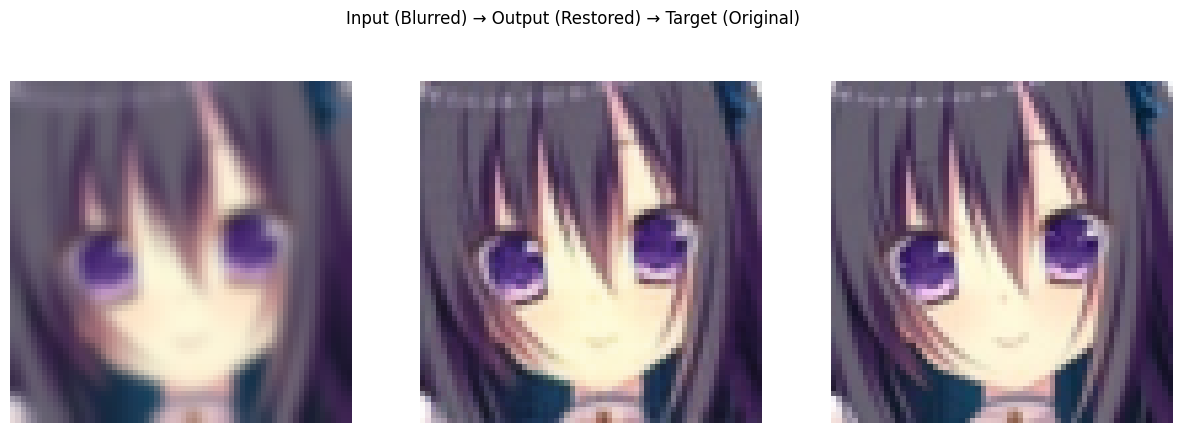

In [19]:
gen.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs = inputs.to(device)
    outputs = gen(inputs)

    # Move to CPU for plotting
    inputs = inputs.cpu()
    outputs = outputs.cpu()
    targets = targets.cpu()

    def show_images(img_list, title):
        fig, axs = plt.subplots(1, len(img_list), figsize=(15,5))
        for i, img in enumerate(img_list):
            img = denormalize(img)
            axs[i].imshow(img.permute(1,2,0).numpy())
            axs[i].axis("off")
        plt.suptitle(title)
        plt.show()

    show_images([inputs[0], outputs[0], targets[0]], "Input (Blurred) → Output (Restored) → Target (Original)")
